<a href="https://colab.research.google.com/github/andreadosi1986/PrismaSVDUNet/blob/master/ProgettoCariocaBrazil3SvaluesNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio
!pip install fiona

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 283 kB/s 


In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.2 MB/s 


In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.animation as animation
from matplotlib import rc
import rasterio
from rasterio import mask
import fiona
import skimage
from skimage.measure import regionprops
import random
import pandas as pd
from skimage import filters
import patchify
import tifffile as tiff
import tensorflow as tf
import keras
from patchify import patchify, unpatchify
from scipy.ndimage import rotate
import fiona
from rasterio.plot import reshape_as_image
import tensorflow.keras.utils

In [ ]:
#TOTAL NUMPY CUBE
#numpy_cube = rasterio.open('/content/drive/MyDrive/datamining/prisma/Brazil/PRS_L2C_STD_20220521130548_20220521130552_0001_FULL.tif').read()
#numpy_cube = rasterio.open('/content/drive/MyDrive/datamining/prisma/Brazil/PRS_L2C_STD_20210715102524_20210715102528_0001_FULLNew.tif').read()
numpy_cube = rasterio.open('/content/drive/MyDrive/datamining/prisma/Brazil/PRS_L2C_STD_20220521130548_20220521130552_0001_FULLNew2.tif').read()


In [ ]:
numpy_cube.shape

(231, 1274, 1421)

209


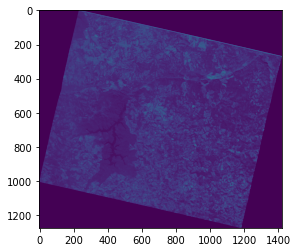

In [ ]:
from random import randint

value = randint(0, 231)
print(value)
plt.imshow(numpy_cube[value,:,:])
plt.show()

In [ ]:
print(np.max(numpy_cube), np.min(numpy_cube))

2.7287614 0.0


In [ ]:
### Function to remove noise bands (systematic by prisma)
#CUTS: FROM 1,317 to 1,533 nm and FROM 1,784 to 2,035 nm"
def filter(numpy_cube):
    numpy_cube_cut1 = numpy_cube[0:96]
    numpy_cube_cut2 = numpy_cube[117:141]
    numpy_cube_cut3 = numpy_cube[170:232]
    numpy_cube_cut = np.concatenate((numpy_cube_cut1, numpy_cube_cut2, numpy_cube_cut3), axis=0)

    return numpy_cube_cut

In [ ]:
total_cube = filter(numpy_cube)
print(total_cube.shape)

(181, 1274, 1421)


In [ ]:
bands = total_cube.shape[0]
lst=[]
for i in range (bands):
  rotate_cube = rotate(total_cube[i,:,:], angle=14.1, reshape=False, order=0)
  lst.append(rotate_cube)
temp_brazil_cube = np.array(lst)
temp_brazil_reshape = reshape_as_image(temp_brazil_cube)

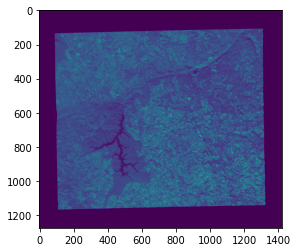

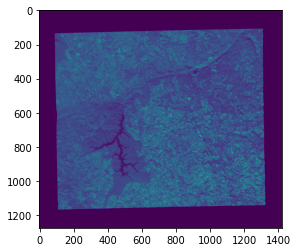

In [ ]:
plt.imshow(temp_brazil_cube[100,:,:])
plt.show()
plt.imshow(temp_brazil_reshape[:,:,100])
plt.show()


In [ ]:
final_brazil_array = temp_brazil_reshape[150:1100, 150:1100, :]

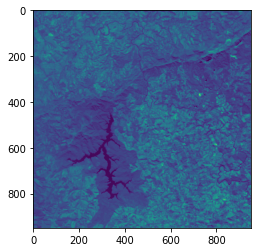

In [ ]:
plt.imshow(final_brazil_array[:,:,100])
plt.show()

In [ ]:
###### SINGULAR VALUES DECOMPOSITION ####

In [ ]:
#build the 2d array for svd
svd_cube = np.reshape(final_brazil_array, (final_brazil_array.shape[0]*final_brazil_array.shape[1], final_brazil_array.shape[2]))
svd_cube.shape

(902500, 181)

In [ ]:
#SVD application
#from sklearn.decomposition import TruncatedSVD

#svd = TruncatedSVD(n_components=1)
#svd.fit(svd_cube)
#total_transf_cube = svd.transform(svd_cube)

In [ ]:
import pickle
loaded_model = pickle.load(open('/content/drive/MyDrive/datamining/prisma/Sardinia/SvdSardinia3Comp.sav', 'rb'))
total_transf_cube = loaded_model.transform(svd_cube)

In [ ]:
print(np.min(total_transf_cube), np.max(total_transf_cube), total_transf_cube.shape)

-1.3305935 5.6668625 (902500, 3)


In [ ]:
loaded_norm = pickle.load(open('/content/drive/MyDrive/datamining/prisma/Sardinia/SvdSardinia3CompNormalization.sav', 'rb'))
total_transf_cube = loaded_norm.transform(total_transf_cube)

In [ ]:
print(np.min(total_transf_cube), np.max(total_transf_cube), total_transf_cube.shape)

0.049929887 0.9490777 (902500, 3)


In [ ]:
#after the svd transformation, reshape the array as an 3D image 
svd_array = np.reshape(total_transf_cube, (final_brazil_array.shape[0],final_brazil_array.shape[1],total_transf_cube.shape[1]))

In [ ]:
print(svd_array.shape)

(950, 950, 3)


In [ ]:
#normalize from 0 to 1 the image dividing to the Sardinia MAX
#sardnina_svd_max = 7.0863256
svd_array_norm = svd_array

In [ ]:
#check if it is correctly normalized
print("the cube minimum is", np.min(svd_array_norm),"     ", "the cube maximum is",  np.max(svd_array_norm))

the cube minimum is 0.049929887       the cube maximum is 0.9490777


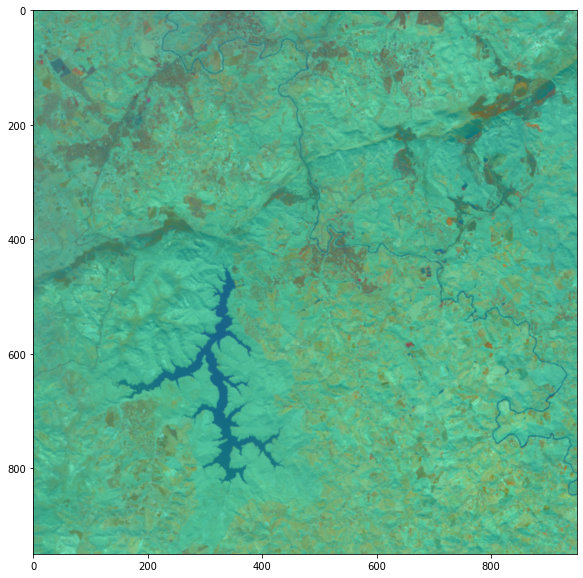

In [ ]:
#plot the brazil image
plt.figure(figsize=(20,10))

plt.imshow(svd_array_norm)
plt.savefig("/content/drive/MyDrive/datamining/prisma/Brazil/BrasilArea.pdf", bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
###### DIVIDE THE ORIGINAL PICTURE AND THE MASK IN PATCHES OF 128 PIXELS WITH NO OVERLAP ######

In [ ]:
patches = patchify(svd_array_norm, (128,128,3), step = 128)

In [ ]:
print(patches.shape)

(7, 7, 1, 128, 128, 3)


In [ ]:
patches_res = patches.reshape(patches.shape[0] * patches.shape[1], patches.shape[3], patches.shape[4], patches.shape[5])

In [ ]:
patches_res.shape

(49, 128, 128, 3)

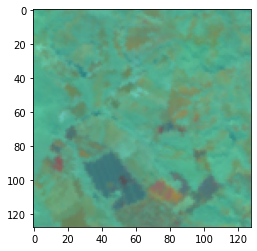

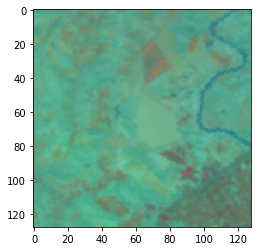

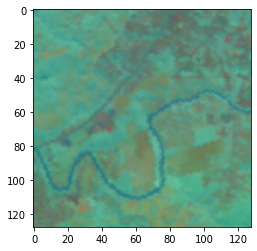

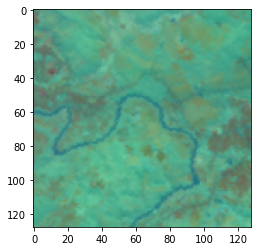

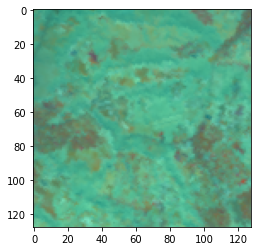

In [ ]:
for i in range (0,5):
  plt.imshow(patches_res[i,:,:])
  plt.show() 

In [ ]:
model_saved =  keras.models.load_model('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNet_200Ep4Classes3ChannelsWithNoise',compile=False)


In [ ]:
prediction = model_saved.predict(patches_res)
#predicted_img=np.argmax(prediction, axis=3)[0,:,:]

In [ ]:
prediction.shape

(49, 128, 128, 4)

In [ ]:
predict = []
for i in range (prediction.shape[0]):
  predicted_img=np.argmax(prediction, axis=3)[i,:,:]
  predict.append(predicted_img)
prd = np.array(predict)

In [ ]:
prd.shape

(49, 128, 128)

In [ ]:
print(prediction.shape, predicted_img.shape, prd.shape)

(49, 128, 128, 4) (128, 128) (49, 128, 128)


In [ ]:
np.unique(prd)

array([0, 1, 2, 3])

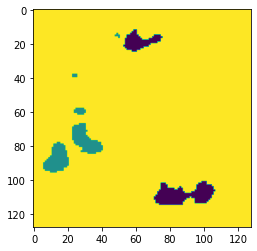

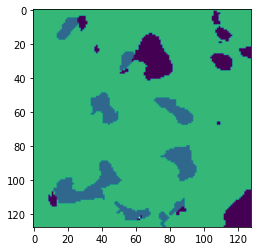

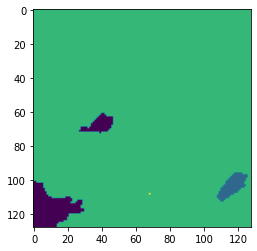

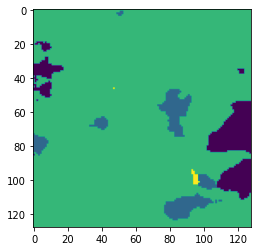

In [ ]:
for i in range (4):  
  plt.imshow(prd[i])
  plt.show()

In [ ]:
#(7, 5, 128, 128)

In [ ]:
brazil_patches = prd.reshape(7, 7, 128, 128)

In [ ]:
brazil_patches.shape

(7, 7, 128, 128)

In [ ]:
unpatched_prediction = unpatchify(brazil_patches, (7*128, 7*128))

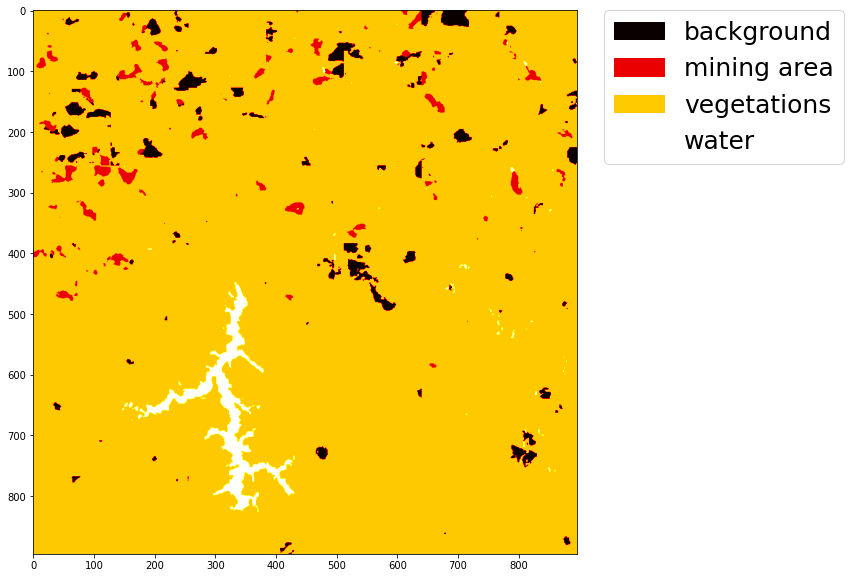

In [ ]:
import matplotlib.patches as mpatches
values = np.unique(unpatched_prediction)
label = ["background","mining area", "vegetations", "water"]
plt.figure(figsize=(20,10))
im_gr_tr = plt.imshow(unpatched_prediction, cmap='hot')
#plt.figure(figsize=(24,12))
colors = [im_gr_tr.cmap(im_gr_tr.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=label[i])  for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, prop={'size': 25}, borderaxespad=0. )
#plt.savefig("/content/drive/MyDrive/datamining/prisma/Brazil/Prediction.pdf", bbox_inches='tight', format = 'pdf')

plt.show()

In [ ]:
#brazil_im = brazil_patches.reshape(1*128, 34*128)

In [ ]:
np.unique(unpatched_prediction)

array([0, 1, 2, 3])

In [ ]:
##### PATCH THE GROUND TRUTH

In [ ]:
#IOU
y_pred=prediction
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
brazil_gt = np.load('/content/drive/MyDrive/datamining/prisma/Brazil/BrazilGtHighResolution.npy')

In [ ]:
brazil_gt.shape

(950, 950)

In [ ]:
gt_patch = patchify(brazil_gt, (128,128), step = 128)

In [ ]:
gt_patch.shape

(7, 7, 128, 128)

In [ ]:
print(unpatched_prediction.shape, brazil_gt.shape)

(896, 896) (950, 950)


In [ ]:
unpatched_gt = unpatchify(gt_patch, (7*128, 7*128))

In [ ]:
unpatched_gt.shape

(896, 896)

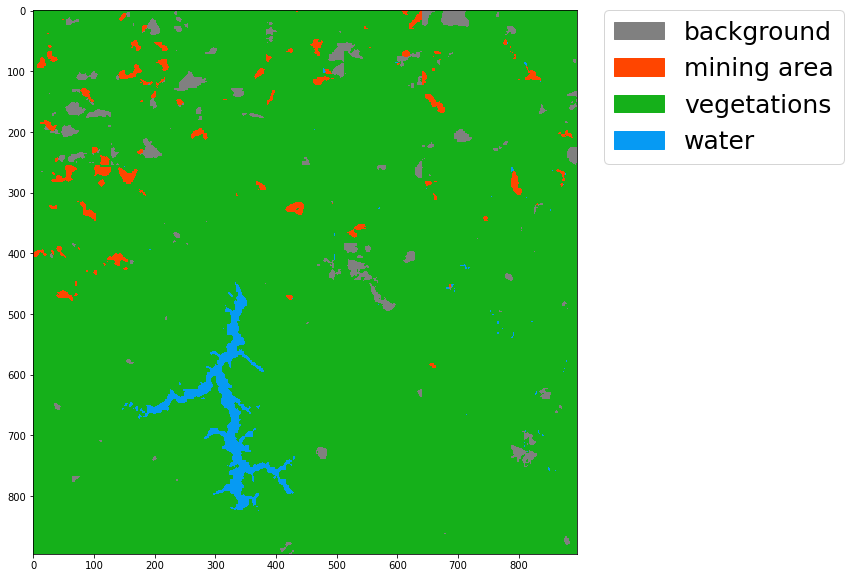

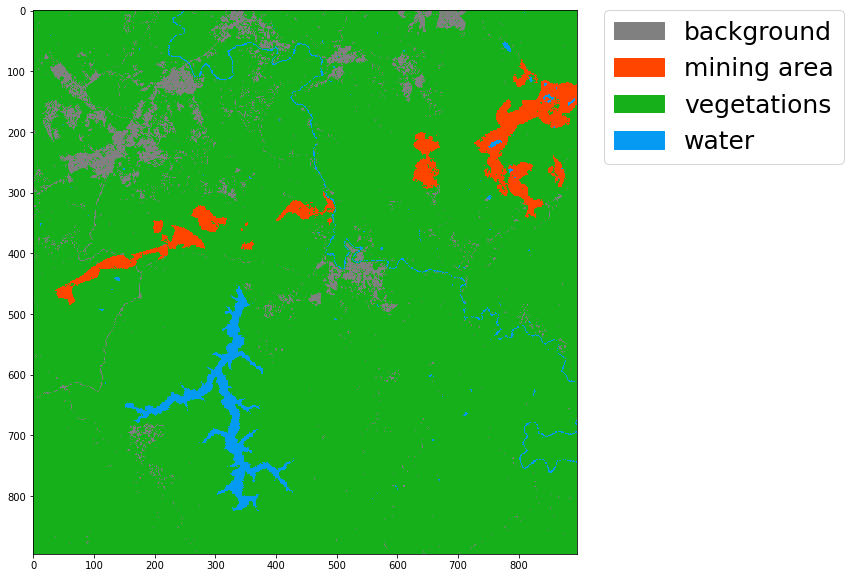

In [ ]:
import matplotlib.patches as mpatches
## PLOT BRAZIL PREDICTION
values = np.unique(unpatched_prediction)
label = ["background","mining area", "vegetations", "water"]
colors = ['gray', '#FF4500', '#15B01A', '#069AF3']
bounds = [0,1,2,3,4]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(20,10))
im_gr_tr = plt.imshow(unpatched_prediction, interpolation='none', cmap=cmap, norm=norm)
#plt.figure(figsize=(24,12))
colors = [im_gr_tr.cmap(im_gr_tr.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=label[i])  for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2,  prop={'size': 25}, borderaxespad=0. )
plt.savefig("/content/drive/MyDrive/datamining/prisma/Brazil/PredictionNew.pdf", format = 'pdf', bbox_inches='tight')
plt.savefig("/content/drive/MyDrive/datamining/prisma/Brazil/PredictionNew.png", format = 'png', bbox_inches='tight')

plt.show()

#PLOT BRAZIL GROUND TRUTH
values = np.unique(unpatched_gt)
label = ["background","mining area", "vegetations", "water"]
colors = ['gray', '#FF4500', '#15B01A', '#069AF3']
bounds = [0,1,2,3,4]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(20,10))
im_gr_tr = plt.imshow(unpatched_gt, interpolation='none', cmap=cmap, norm=norm)
#plt.figure(figsize=(24,12))
colors = [im_gr_tr.cmap(im_gr_tr.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=label[i])  for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, prop={'size': 25}, borderaxespad=0. )
plt.savefig("/content/drive/MyDrive/datamining/prisma/Brazil/GroundTruthNew.pdf", format = 'pdf', bbox_inches='tight')
plt.savefig("/content/drive/MyDrive/datamining/prisma/Brazil/GroundTruthNew.png", format = 'png', bbox_inches='tight')

plt.show()

In [ ]:
y_test = gt_patch.reshape(49, gt_patch.shape[2], gt_patch.shape[3])

In [ ]:
y_test.shape

(49, 128, 128)

In [ ]:
##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
#class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[0,4]+ values[1,4]+ values[2,4])
#class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[0,5]+ values[1,5]+ values[2,5])

print("IoU for background is: ", class1_IoU)
print("IoU for mining area: ", class2_IoU)
print("IoU for vegetations is: ", class3_IoU)
print("IoU for water is: ", class4_IoU)
#print("IoU for sparse veg is: ", class5_IoU)
#print("IoU for urban area is: ", class6_IoU)


#plt.imshow(train_images[0, :,:,0], cmap='gray')
#plt.imshow(train_masks[0, :,:,0], cmap='gray')
#######################################################################v

Mean IoU = 0.41681576
[[6.2350e+03 2.4360e+03 2.6620e+04 8.0000e+00]
 [9.0500e+02 1.7750e+03 1.9565e+04 3.5000e+01]
 [8.5150e+03 6.0060e+03 7.1225e+05 2.0730e+03]
 [1.5600e+02 7.0000e+01 5.8290e+03 1.0338e+04]]
IoU for background is:  0.13894151
IoU for mining area:  0.057644844
IoU for vegetations is:  0.9121377
IoU for water is:  0.5585391


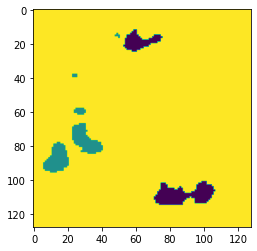

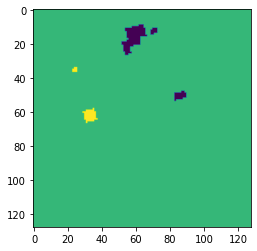

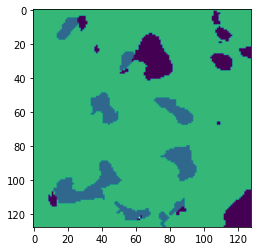

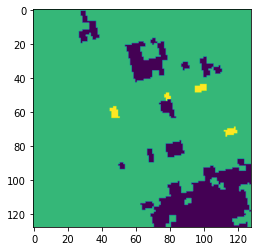

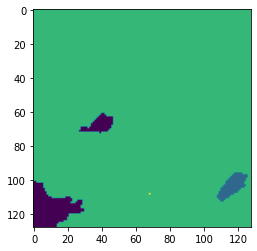

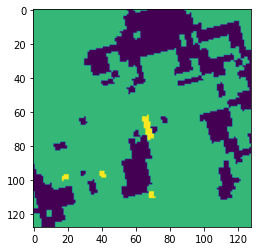

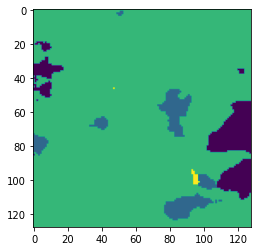

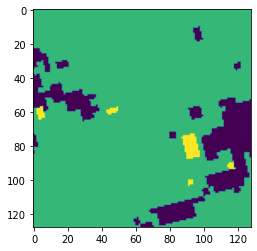

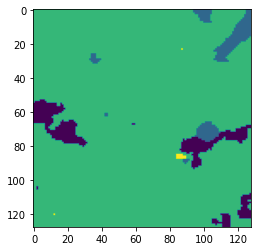

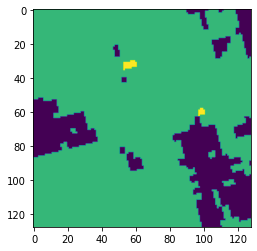

In [ ]:
for i in range (5):
  plt.imshow(y_pred_argmax[i])
  plt.show()
  plt.imshow(y_test[i])
  plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical
n_classes=4 
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
import segmentation_models as sm
focal_loss = sm.losses.CategoricalFocalLoss()

Segmentation Models: using `keras` framework.


In [ ]:
model_saved.compile(optimizer='adam', loss= focal_loss, metrics = ['accuracy'])

In [ ]:
#Evaluate the model
	# evaluate model
_, acc = model_saved.evaluate(patches_res, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

2/2 [==============================] - 3s 707ms/step - loss: 0.1209 - accuracy: 0.7775
Accuracy is =  77.7539312839508 %
